# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [10]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0, engine="openpyxl")

C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\openpyxl\worksheet\_reader.py:300: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### 1b. Explore the data

In [11]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [12]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1, engine="openpyxl")
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

C:\Users\wodar\miniconda3\envs\conda-env\lib\site-packages\openpyxl\worksheet\_reader.py:300: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [33]:
#your turn
customer_offers = pd.pivot_table(data=df_transactions, values='n', index='customer_name', 
                                 columns='offer_id', fill_value=0)
customer_offers.columns = list(map(lambda x: "offer_" + str(x).rjust(2, "0"), customer_offers.columns))
customer_offers = customer_offers.reset_index()
customer_offers.columns.name = None

In [34]:
customer_offers.head()

,customer_name,offer_01,offer_02,offer_03,offer_04,offer_05,offer_06,offer_07,offer_08,offer_09,...,offer_23,offer_24,offer_25,offer_26,offer_27,offer_28,offer_29,offer_30,offer_31,offer_32
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [35]:
customer_offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_name  100 non-null    object
 1   offer_01       100 non-null    int64 
 2   offer_02       100 non-null    int64 
 3   offer_03       100 non-null    int64 
 4   offer_04       100 non-null    int64 
 5   offer_05       100 non-null    int64 
 6   offer_06       100 non-null    int64 
 7   offer_07       100 non-null    int64 
 8   offer_08       100 non-null    int64 
 9   offer_09       100 non-null    int64 
 10  offer_10       100 non-null    int64 
 11  offer_11       100 non-null    int64 
 12  offer_12       100 non-null    int64 
 13  offer_13       100 non-null    int64 
 14  offer_14       100 non-null    int64 
 15  offer_15       100 non-null    int64 
 16  offer_16       100 non-null    int64 
 17  offer_17       100 non-null    int64 
 18  offer_18       100 non-null    

In [36]:
customer_offers.describe()

,offer_01,offer_02,offer_03,offer_04,offer_05,offer_06,offer_07,offer_08,offer_09,offer_10,...,offer_23,offer_24,offer_25,offer_26,offer_27,offer_28,offer_29,offer_30,offer_31,offer_32
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.100000,0.100000,0.060000,0.120000,0.040000,0.120000,0.190000,0.200000,0.100000,0.070000,...,0.050000,0.120000,0.060000,0.15000,0.090000,0.060000,0.170000,0.220000,0.170000,0.040000
std,0.301511,0.301511,0.238683,0.326599,0.196946,0.326599,0.394277,0.402015,0.301511,0.256432,...,0.219043,0.326599,0.238683,0.35887,0.287623,0.238683,0.377525,0.416333,0.377525,0.196946
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [37]:
# your turn
x_cols = customer_offers.drop('customer_name', axis=1).to_numpy()

In [38]:
from sklearn.cluster import KMeans

def apply_kmeans(k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x_cols)
    return kmeans.inertia_

In [46]:
SS = []
max_k = 10
for k in range(2,max_k+1):
    SS.append(apply_kmeans(k))
print(SS)

[251.46031746031747, 228.40809322033905, 215.75324074074075, 204.188774263371, 196.995405982906, 187.7259279664679, 178.48073152337858, 171.16856060606062, 166.12770562770564]


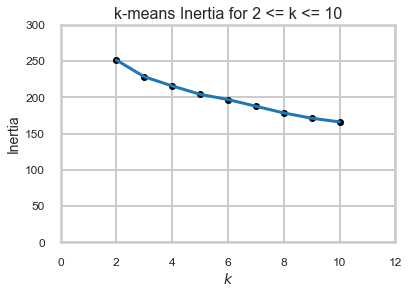

In [115]:
plt.plot(range(2,max_k+1),SS);
plt.scatter(range(2,max_k+1),SS,s=25,c='black',alpha=1);
plt.xlim(0,max_k+2);
plt.tick_params(axis="x", labelsize=12)
plt.ylim(0,300);
plt.tick_params(axis="y", labelsize=12)
plt.xlabel('$k$', fontsize=14);
plt.ylabel('Inertia', fontsize=14);
plt.title('k-means Inertia for 2 <= k <= ' + str(max_k), fontsize=16);

In [53]:
import numpy as np
inertia_diffs = np.array(SS[:-1]) - np.array(SS[1:])
print(inertia_diffs)

[23.05222424 12.65485248 11.56446648  7.19336828  9.26947802  9.24519644
  7.31217092  5.04085498]


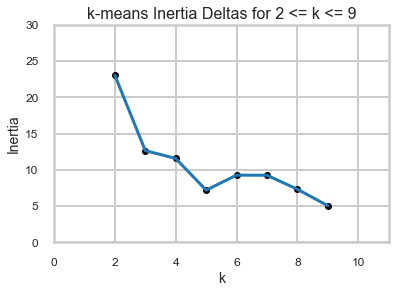

In [116]:
plt.plot(range(2,max_k),inertia_diffs);
plt.scatter(range(2,max_k),inertia_diffs,s=25,c='black',alpha=1);
plt.xlim(0,max_k+1);
plt.tick_params(axis="x", labelsize=12)
plt.ylim(0,30);
plt.tick_params(axis="y", labelsize=12)
plt.xlabel('k', fontsize=14);
plt.ylabel('Inertia', fontsize=14);
plt.title('k-means Inertia Deltas for 2 <= k <= ' + str(max_k-1), fontsize=16);

Visually, there isn't an obvious choice for $k$. Looking at differences suggests taking $k=3$ or $k=10$. We will proceed with $k=3$ as there is a clear divide between the differences from $k=2$ to $k=3$ and the differences from $k=n$ to $k=n+1$ for $n > 2$. 

In [123]:
best_k = 3
kmeans = KMeans(n_clusters=best_k)
kmeans.fit(x_cols);

In [124]:
label_counts = [list(kmeans.labels_).count(i) for i in range(best_k)]
labels = list(range(best_k))

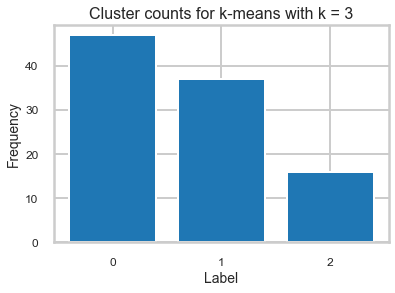

In [125]:
plt.axes().set_xticks(labels) 
plt.bar(range(best_k), label_counts)

plt.xlabel('Label', fontsize=14);
plt.ylabel('Frequency', fontsize=14);
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.title('Cluster counts for k-means with k = ' + str(best_k), fontsize=16);


#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

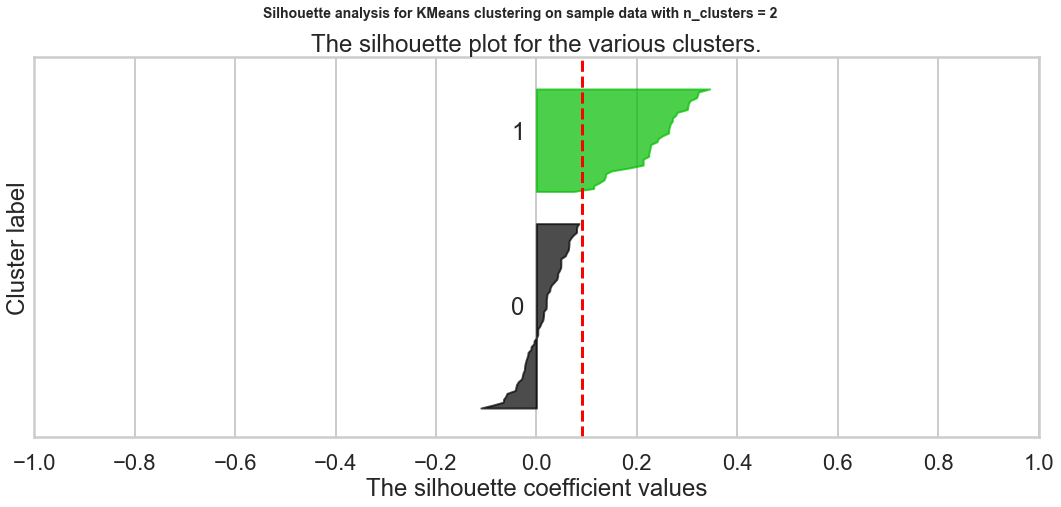

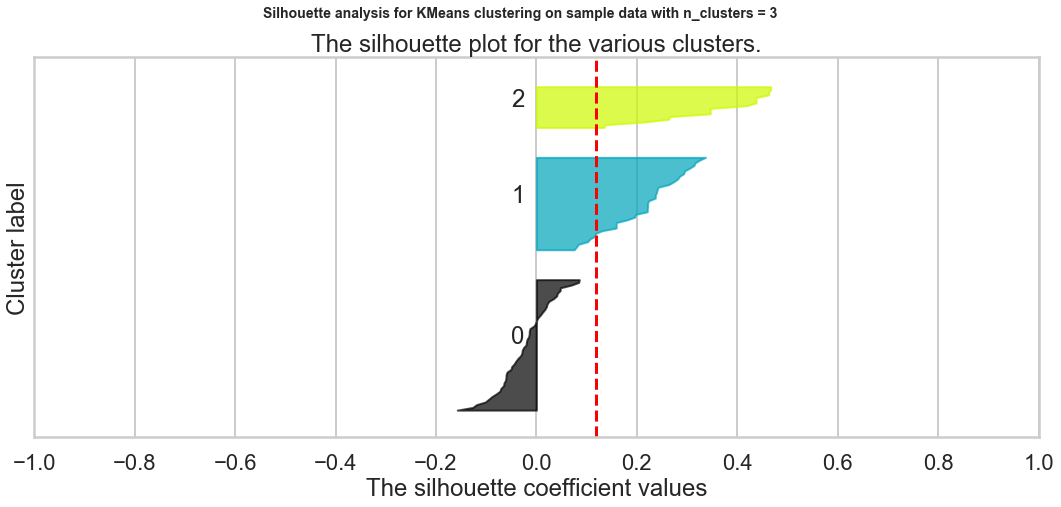

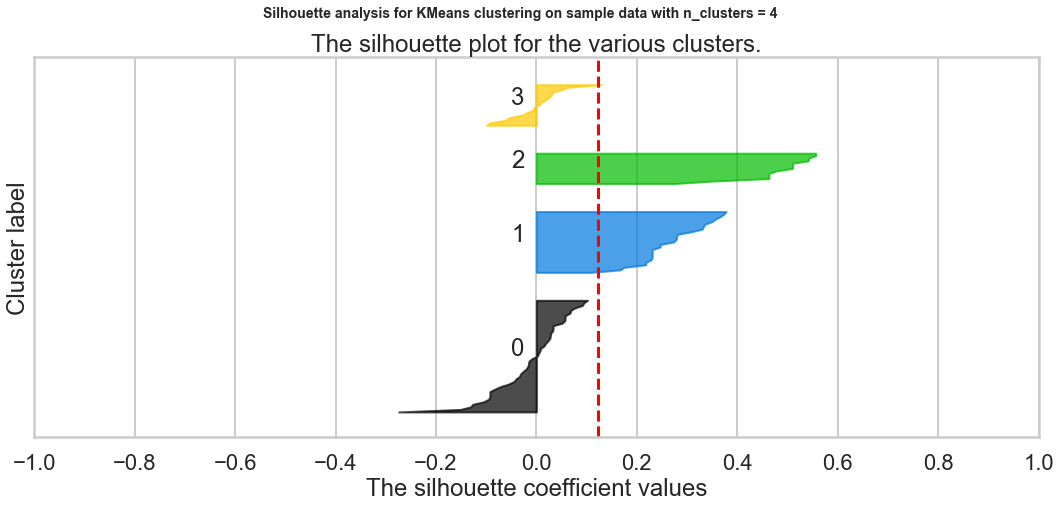

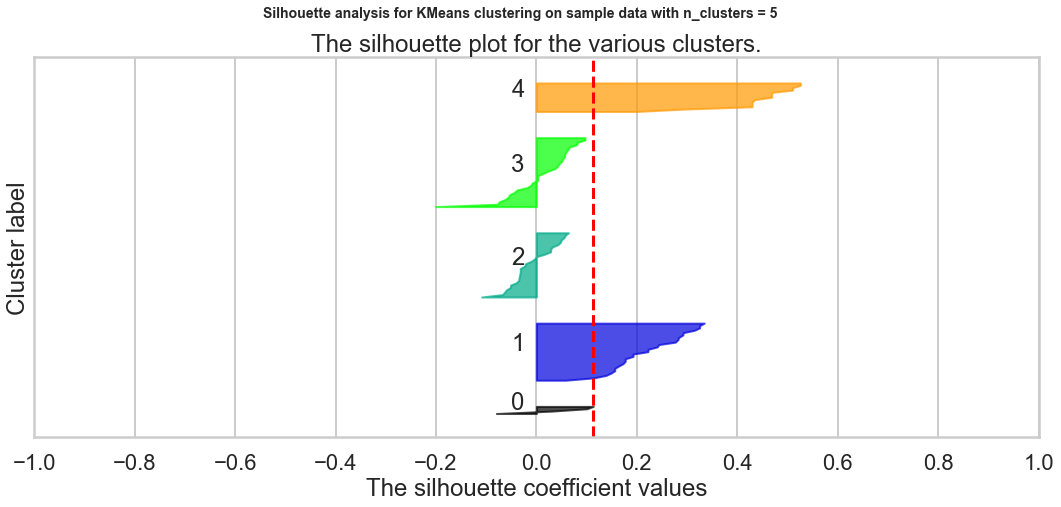

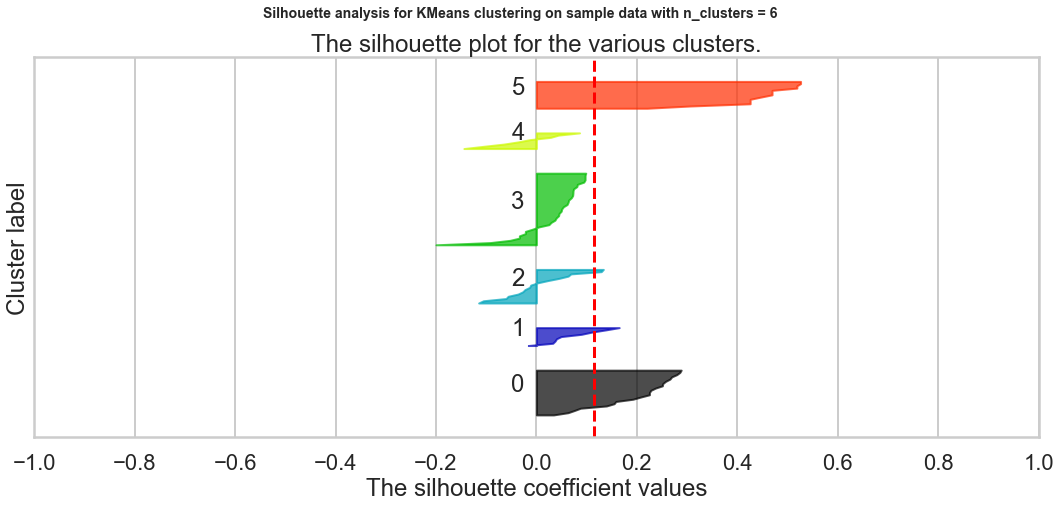

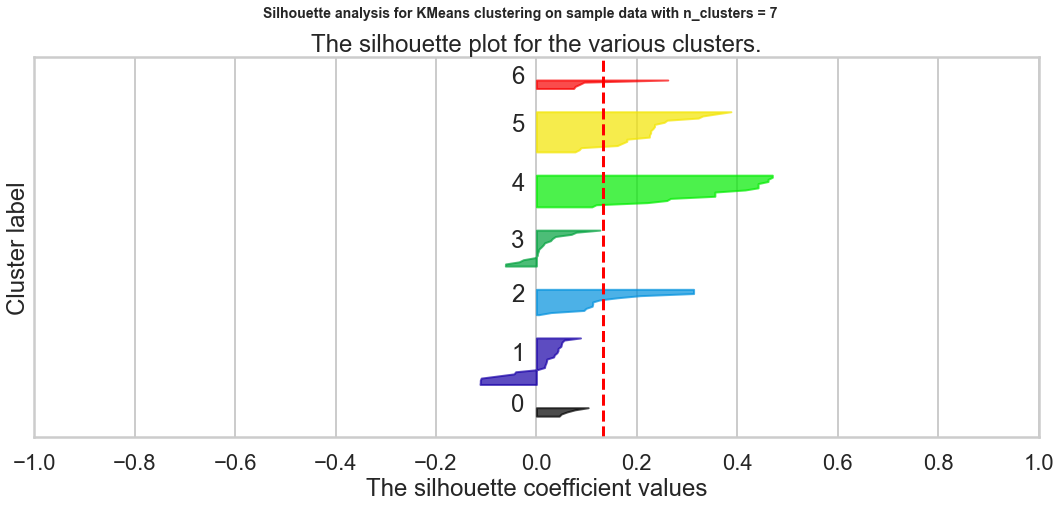

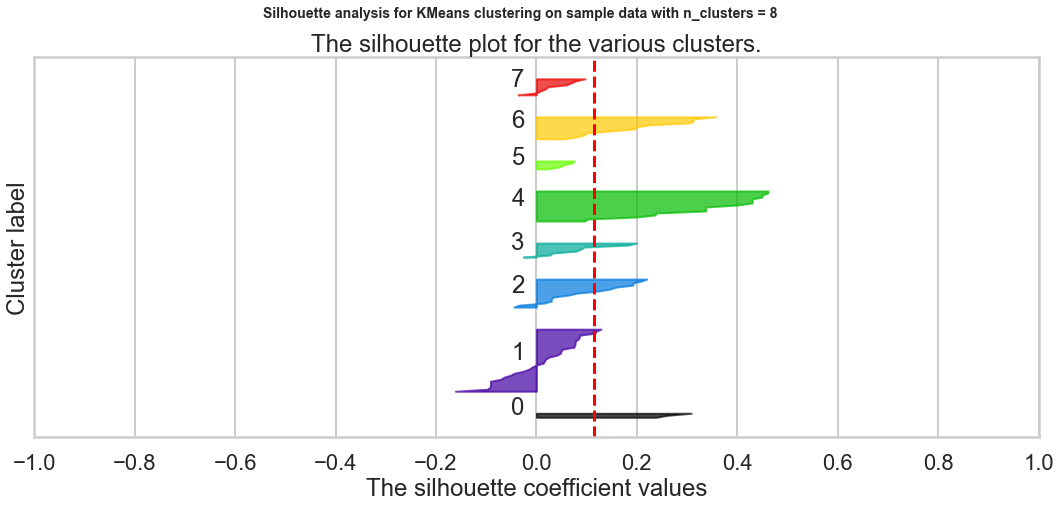

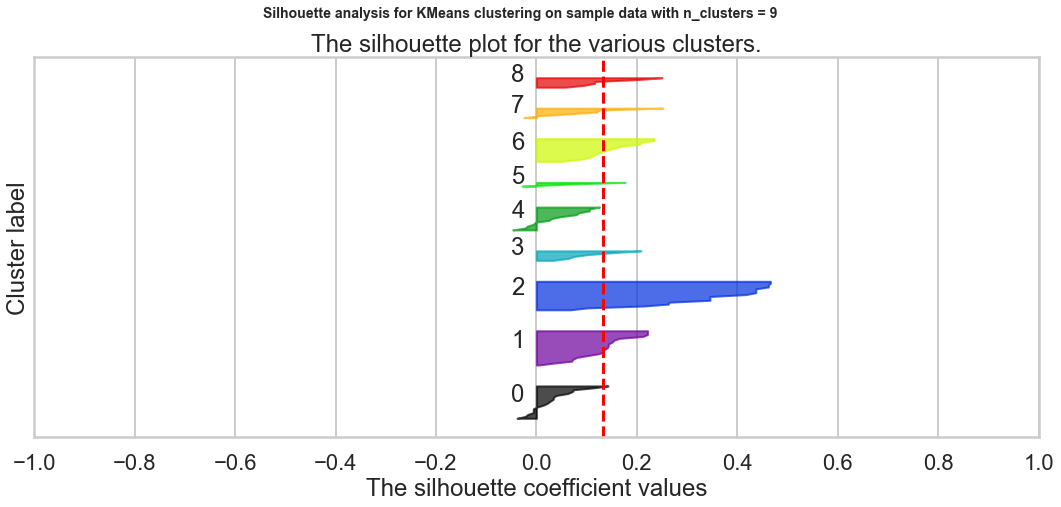

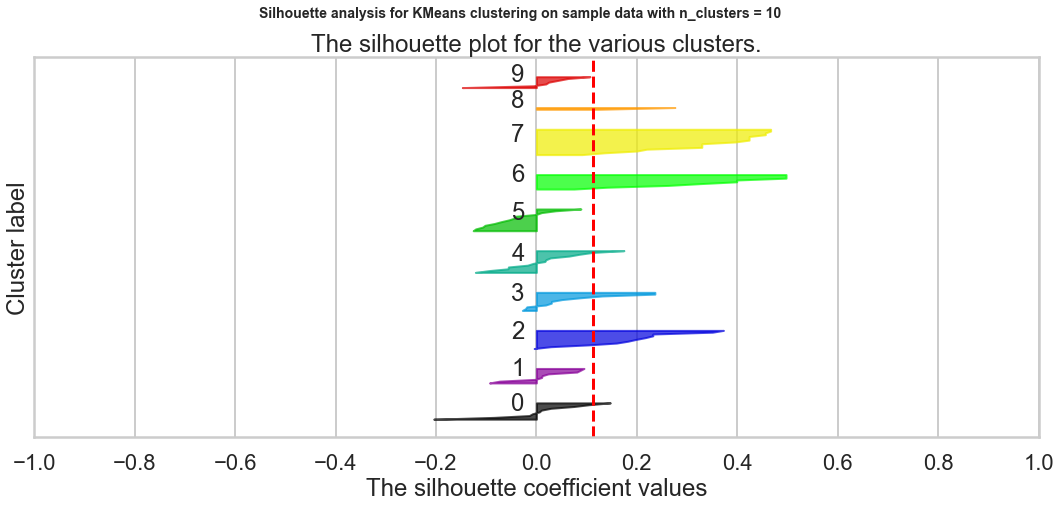

In [142]:
# Your turn.
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

silhouette_scores = []

for k in range(2,max_k+1):
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-1, 1])
    # The (k+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (k + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=k)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

plt.show()

In [146]:
for i in range(len(silhouette_scores)):
    print("For n_clusters =", i+2, "The average silhouette_score is :", silhouette_scores[i])

For n_clusters = 2 The average silhouette_score is : 0.09007566678796264
For n_clusters = 3 The average silhouette_score is : 0.11911443801718427
For n_clusters = 4 The average silhouette_score is : 0.12348665899510185
For n_clusters = 5 The average silhouette_score is : 0.11364297297302418
For n_clusters = 6 The average silhouette_score is : 0.11491735815957735
For n_clusters = 7 The average silhouette_score is : 0.13251196710804147
For n_clusters = 8 The average silhouette_score is : 0.11557133965252152
For n_clusters = 9 The average silhouette_score is : 0.13282158443275643
For n_clusters = 10 The average silhouette_score is : 0.11298595618613072


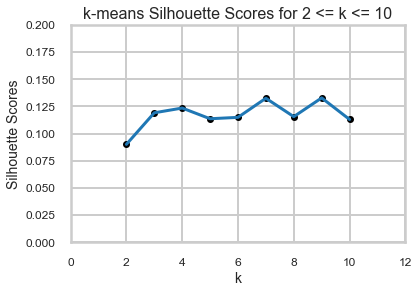

In [150]:
plt.plot(range(2,max_k+1),silhouette_scores);
plt.scatter(range(2,max_k+1),silhouette_scores,s=25,c='black',alpha=1);
plt.xlim(0,max_k+2);
plt.tick_params(axis="x", labelsize=12)
plt.ylim(0,0.2);
plt.tick_params(axis="y", labelsize=12)
plt.xlabel('k', fontsize=14);
plt.ylabel('Silhouette Scores', fontsize=14);
plt.title('k-means Silhouette Scores for 2 <= k <= ' + str(max_k), fontsize=16);

All of the silhouette scores fall into the category where 'No substantial structure has been found'. This indicates that there is no good value of $k$, which agrees with what we saw earlier. There are clearly a number of poorly-categorized items regardless of the choice of $k$.
If our heuristic is to take the maximum silhouette score, the choice would be $k=9$.

In [159]:
max_ss = max(silhouette_scores)
max_idx = silhouette_scores.index(max_ss)
best_ss_k = max_idx + 2
print(f'The maximum silhouette score is found at k={best_ss_k} with a score of {max_ss:.3}')

The maximum silhouette score is found at k=9 with a score of 0.133


In [163]:
best_silhouette_model = KMeans(n_clusters=best_ss_k)
best_silhouette_model.fit(x_cols);

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [184]:
#your turn
from sklearn.decomposition import PCA
pca_model = PCA(n_components=2)
pca_components = pca_model.fit_transform(x_cols);

In [185]:
pca_components.shape

(100, 2)

In [187]:
df = pd.DataFrame()
df['customer_name'] = customer_offers['customer_name']
df['cluster_id'] = best_silhouette_model.labels_
df['x'] = pca_components[:,0]
df['y'] = pca_components[:,1]

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customer_name  100 non-null    object 
 1   cluster_id     100 non-null    int32  
 2   x              100 non-null    float64
 3   y              100 non-null    float64
dtypes: float64(2), int32(1), object(1)
memory usage: 2.9+ KB


In [190]:
df.head()

,customer_name,cluster_id,x,y
0,Adams,4,1.007580,0.108215
1,Allen,3,-0.287539,0.044715
2,Anderson,6,-0.392032,1.038391
3,Bailey,4,0.699477,-0.022542
4,Baker,7,0.088183,-0.471695


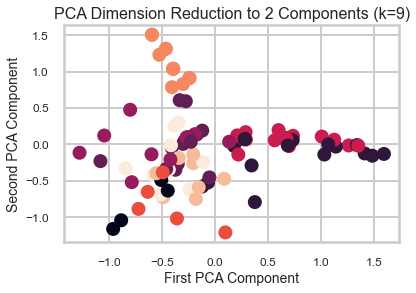

In [213]:
plt.scatter(df['x'], df['y'], c=df['cluster_id']);
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.xlabel('First PCA Component', fontsize=14);
plt.ylabel('Second PCA Component', fontsize=14);
plt.title('PCA Dimension Reduction to 2 Components (k=9)', fontsize=16);

This seems exceedingly bad. Let's compare against the earlier choice of $k=3$, which appears like it might be better based off of this scatter plot.

In [196]:
kmeans_best_inertia = KMeans(n_clusters=3)
kmeans_best_inertia.fit(x_cols)
df2 = pd.DataFrame()
df2['customer_name'] = customer_offers['customer_name']
df2['cluster_id'] = kmeans_best_inertia.labels_
df2['x'] = pca_components[:,0]
df2['y'] = pca_components[:,1]

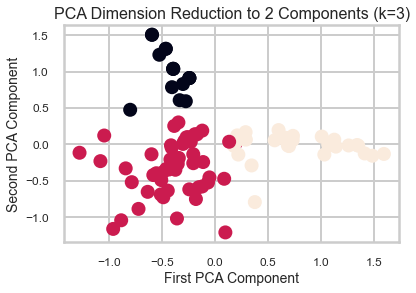

In [214]:
plt.scatter(df2['x'], df2['y'], c=df2['cluster_id']);
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.xlabel('First PCA Component', fontsize=14);
plt.ylabel('Second PCA Component', fontsize=14);
plt.title('PCA Dimension Reduction to 2 Components (k=3)', fontsize=16);

This is much better and appears to be a reasonable choice.

In [279]:
customer_offers['cluster_id'] = df2['cluster_id'] = kmeans_best_inertia.labels_
offer_clusters = customer_offers.drop('customer_name', axis=1)

In [280]:
offer_clusters = offer_clusters.groupby(by='cluster_id').sum()
offer_clusters['cluster_size'] = df2['cluster_id'].value_counts()
offer_clusters

,offer_01,offer_02,offer_03,offer_04,offer_05,offer_06,offer_07,offer_08,offer_09,offer_10,...,offer_24,offer_25,offer_26,offer_27,offer_28,offer_29,offer_30,offer_31,offer_32,cluster_size
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,1,6,0,0,0,0,0,0,0,1,...,12,0,12,1,0,0,0,0,0,16
1,9,4,4,12,4,11,3,3,10,4,...,0,6,3,7,5,1,6,17,4,49
2,0,0,2,0,0,1,16,17,0,2,...,0,0,0,1,1,16,16,0,0,35


In [281]:
offer_clusters = offer_clusters.iloc[:, :-1].divide(offer_clusters.iloc[:,-1], axis = 'rows')
offer_clusters

,offer_01,offer_02,offer_03,offer_04,offer_05,offer_06,offer_07,offer_08,offer_09,offer_10,...,offer_23,offer_24,offer_25,offer_26,offer_27,offer_28,offer_29,offer_30,offer_31,offer_32
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,0.062500,0.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,...,0.062500,0.75,0.000000,0.750000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.183673,0.081633,0.081633,0.244898,0.081633,0.224490,0.061224,0.061224,0.204082,0.081633,...,0.081633,0.00,0.122449,0.061224,0.142857,0.102041,0.020408,0.122449,0.346939,0.081633
2,0.000000,0.000000,0.057143,0.000000,0.000000,0.028571,0.457143,0.485714,0.000000,0.057143,...,0.000000,0.00,0.000000,0.000000,0.028571,0.028571,0.457143,0.457143,0.000000,0.000000


In [282]:
df_offers['cluster_0'] = offer_clusters.T[0].reset_index(drop=True)
df_offers['cluster_1'] = offer_clusters.T[1].reset_index(drop=True)
df_offers['cluster_2'] = offer_clusters.T[2].reset_index(drop=True)
df_offers

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,cluster_0,cluster_1,cluster_2
0,1,January,Malbec,72,56,France,False,0.0625,0.183673,0.000000
1,2,January,Pinot Noir,72,17,France,False,0.3750,0.081633,0.000000
2,3,February,Espumante,144,32,Oregon,True,0.0000,0.081633,0.057143
3,4,February,Champagne,72,48,France,True,0.0000,0.244898,0.000000
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True,0.0000,0.081633,0.000000
5,6,March,Prosecco,144,86,Chile,False,0.0000,0.224490,0.028571
6,7,March,Prosecco,6,40,Australia,True,0.0000,0.061224,0.457143
7,8,March,Espumante,6,45,South Africa,False,0.0000,0.061224,0.485714
8,9,April,Chardonnay,144,57,Chile,False,0.0000,0.204082,0.000000
9,10,April,Prosecco,72,52,California,False,0.0625,0.081633,0.057143


In [283]:
pd.pivot_table(df_offers, index='varietal', values=['cluster_0', 'cluster_1', 'cluster_2'], aggfunc=np.mean)

,cluster_0,cluster_1,cluster_2
varietal,,,
Cabernet Sauvignon,0.000000,0.105442,0.004762
Champagne,0.008929,0.218659,0.020408
Chardonnay,0.031250,0.142857,0.000000
Espumante,0.000000,0.054422,0.304762
Malbec,0.031250,0.153061,0.228571
Merlot,0.020833,0.088435,0.057143
Pinot Grigio,0.000000,0.020408,0.457143
Pinot Noir,0.578125,0.035714,0.000000
Prosecco,0.031250,0.107143,0.142857


In [284]:
pd.pivot_table(df_offers, index='origin', values=['cluster_0', 'cluster_1', 'cluster_2'], aggfunc=np.mean)

,cluster_0,cluster_1,cluster_2
origin,,,
Australia,0.270833,0.061224,0.161905
California,0.041667,0.068027,0.038095
Chile,0.000000,0.153061,0.050000
France,0.048611,0.197279,0.107937
Germany,0.145833,0.054422,0.009524
Italy,0.250000,0.081633,0.000000
New Zealand,0.031250,0.112245,0.014286
Oregon,0.000000,0.074830,0.142857
South Africa,0.031250,0.071429,0.242857


In [285]:
pd.pivot_table(df_offers, index='campaign', values=['cluster_0', 'cluster_1', 'cluster_2'], aggfunc=np.mean)

,cluster_0,cluster_1,cluster_2
campaign,,,
April,0.031250,0.142857,0.028571
August,0.000000,0.190476,0.028571
December,0.000000,0.183673,0.152381
February,0.000000,0.136054,0.019048
January,0.218750,0.132653,0.000000
July,0.145833,0.034014,0.133333
June,0.020833,0.129252,0.000000
March,0.000000,0.115646,0.323810
May,0.020833,0.108844,0.066667


In [286]:
pd.pivot_table(df_offers, index='past_peak', values=['cluster_0', 'cluster_1', 'cluster_2'], aggfunc=np.mean)

,cluster_0,cluster_1,cluster_2
past_peak,,,
False,0.1075,0.120000,0.088000
True,0.0000,0.110787,0.077551


In [287]:
pd.pivot_table(df_offers, index='discount', values=['cluster_0', 'cluster_1', 'cluster_2'], aggfunc=np.mean)

,cluster_0,cluster_1,cluster_2
discount,,,
17,0.37500,0.081633,0.000000
19,0.00000,0.122449,0.000000
32,0.00000,0.081633,0.057143
34,0.75000,0.000000,0.000000
39,0.06250,0.081633,0.000000
40,0.00000,0.061224,0.457143
43,0.00000,0.000000,0.171429
44,0.00000,0.081633,0.000000
45,0.00000,0.071429,0.242857


In [288]:
pd.pivot_table(df_offers, index='min_qty', values=['cluster_0', 'cluster_1', 'cluster_2'], aggfunc=np.mean)

,cluster_0,cluster_1,cluster_2
min_qty,,,
6,0.107143,0.040816,0.342857
12,0.109375,0.056122,0.028571
72,0.049107,0.172012,0.010204
144,0.116071,0.122449,0.012245


Two of the clusters (`cluster_0` and `cluster_2` appear to concentrate more on the types of wine offered, while `cluster_1` appears to want larger discounts (regardless of the type offered). 

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [205]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca_components = pca.fit_transform(x_cols)

# Do the rest on your own :)
pca.explained_variance_ratio_

array([0.14386393, 0.10800289, 0.07104281, 0.05866151, 0.05273181,
       0.05037351, 0.04853032, 0.04281792, 0.04086488, 0.03794334,
       0.03490044, 0.03334871, 0.03051951, 0.02548482, 0.02321341,
       0.02193338, 0.01978732, 0.01870919, 0.016607  , 0.0154309 ,
       0.01369783, 0.01273333, 0.01213607, 0.01136126, 0.01032716,
       0.00919489, 0.00810601, 0.00752468, 0.00660726, 0.00580346,
       0.0050086 , 0.00273186])

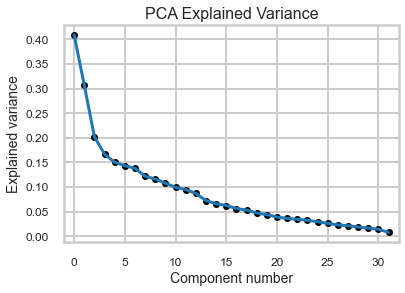

In [212]:
plt.plot(range(len(pca.explained_variance_ratio_)),pca.explained_variance_);
plt.scatter(range(len(pca.explained_variance_ratio_)),pca.explained_variance_,s=25,c='black',alpha=1);
plt.xlim(-1,len(pca.explained_variance_ratio_));
plt.tick_params(axis="x", labelsize=12)
#plt.ylim(0,0.15);
plt.tick_params(axis="y", labelsize=12)
plt.xlabel('Component number', fontsize=14);
plt.ylabel('Explained variance', fontsize=14);
plt.title('PCA Explained Variance', fontsize=16);

Based on this, it appears that reducing to three dimensions instead of two would have better.

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [296]:
# Your turn
from sklearn.cluster import AffinityPropagation
ap_model = AffinityPropagation(random_state=None)
cluster_labels = ap_model.fit_predict(x_cols)
len(ap_model.cluster_centers_)

14

In [297]:
silhouette_score(x_cols, cluster_labels)

0.1287642308248531

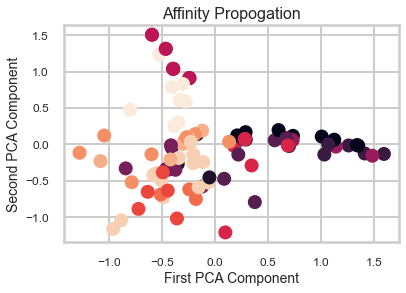

In [298]:
df2['cluster_id'] = cluster_labels
plt.scatter(df2['x'], df2['y'], c=df2['cluster_id']);
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.xlabel('First PCA Component', fontsize=14);
plt.ylabel('Second PCA Component', fontsize=14);
plt.title('Affinity Propogation', fontsize=16);

In [300]:
from sklearn.cluster import SpectralClustering
sc_model = SpectralClustering(n_clusters=3)
cluster_labels = sc_model.fit_predict(x_cols)

In [301]:
silhouette_score(x_cols, cluster_labels)

0.10611539040197304

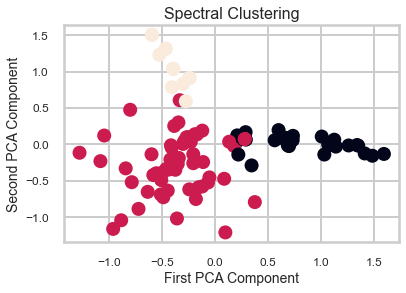

In [302]:
df2['cluster_id'] = cluster_labels
plt.scatter(df2['x'], df2['y'], c=df2['cluster_id']);
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.xlabel('First PCA Component', fontsize=14);
plt.ylabel('Second PCA Component', fontsize=14);
plt.title('Spectral Clustering (3 clusters)', fontsize=16);

In [303]:
sc_model = SpectralClustering(n_clusters=2)
cluster_labels = sc_model.fit_predict(x_cols)
silhouette_score(x_cols, cluster_labels)

0.07631909829627558

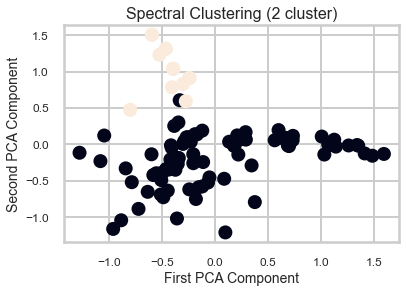

In [304]:
df2['cluster_id'] = cluster_labels
plt.scatter(df2['x'], df2['y'], c=df2['cluster_id']);
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.xlabel('First PCA Component', fontsize=14);
plt.ylabel('Second PCA Component', fontsize=14);
plt.title('Spectral Clustering (2 clusters)', fontsize=16);

In [305]:
sc_model = SpectralClustering(n_clusters=4)
cluster_labels = sc_model.fit_predict(x_cols)
silhouette_score(x_cols, cluster_labels)

0.08627893400734331

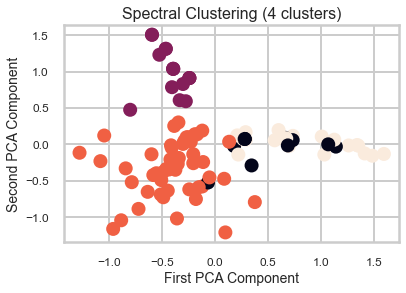

In [306]:
df2['cluster_id'] = cluster_labels
plt.scatter(df2['x'], df2['y'], c=df2['cluster_id']);
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.xlabel('First PCA Component', fontsize=14);
plt.ylabel('Second PCA Component', fontsize=14);
plt.title('Spectral Clustering (4 clusters)', fontsize=16);

In [319]:
from sklearn.cluster import AgglomerativeClustering
ac_model = AgglomerativeClustering(n_clusters=3)
cluster_labels = ac_model.fit_predict(x_cols)
silhouette_score(x_cols, cluster_labels)

0.11625878863607858

In [320]:
ac_model.n_clusters_

3

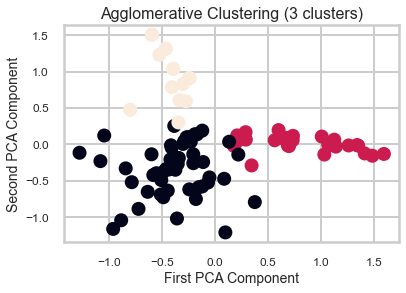

In [321]:
df2['cluster_id'] = cluster_labels
plt.scatter(df2['x'], df2['y'], c=df2['cluster_id']);
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.xlabel('First PCA Component', fontsize=14);
plt.ylabel('Second PCA Component', fontsize=14);
plt.title('Agglomerative Clustering (3 clusters)', fontsize=16);

In [323]:
from sklearn.cluster import DBSCAN
db_model = DBSCAN()
cluster_labels = db_model.fit_predict(x_cols)
silhouette_score(x_cols, cluster_labels)

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

This is a telling error, since only one cluster is found.

In [344]:
pd.DataFrame(cluster_labels)[0].value_counts()

-1    100
Name: 0, dtype: int64

In [343]:
pd.DataFrame(cluster_labels)[0].nunique()

1

Moreover, every point is coded as 'noise'.

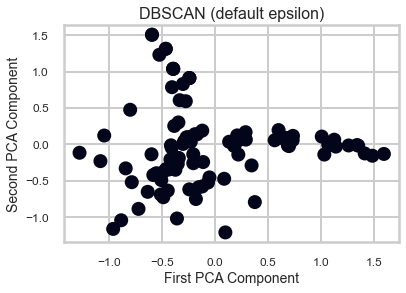

In [331]:
df2['cluster_id'] = cluster_labels
plt.scatter(df2['x'], df2['y'], c=df2['cluster_id']);
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.xlabel('First PCA Component', fontsize=14);
plt.ylabel('Second PCA Component', fontsize=14);
plt.title('DBSCAN (default epsilon)', fontsize=16);

In [347]:
eps_list = [100, 10, 1, 0.1, 0.01, 0.001]
cluster_sizes = []
for eps in eps_list:
    db_model = DBSCAN(eps=eps)
    cluster_labels = db_model.fit_predict(x_cols)
    cluster_sizes.append(pd.DataFrame(cluster_labels)[0].nunique())
cluster_sizes

[1, 1, 5, 1, 1, 1]

Interesting, most values for epsilon give only one cluster, but 1 gives more.

In [350]:
eps_list = np.arange(.5, 2.6, 0.1)
cluster_sizes = []
for eps in eps_list:
    db_model = DBSCAN(eps=eps)
    cluster_labels = db_model.fit_predict(x_cols)
    cluster_sizes.append(pd.DataFrame(cluster_labels)[0].nunique())
cluster_sizes

[1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1]

This would suggest either 5 or 2 clusters.

In [352]:
db_model = DBSCAN(eps=1.0)
cluster_labels = db_model.fit_predict(x_cols)
silhouette_score(x_cols, cluster_labels)

0.012715203274911742

In [354]:
pd.DataFrame(cluster_labels)[0].nunique()

5

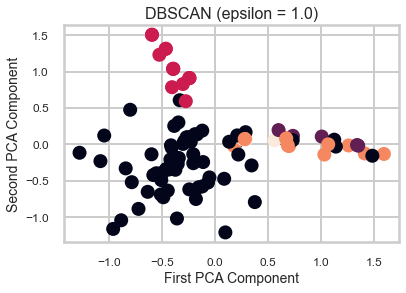

In [353]:
df2['cluster_id'] = cluster_labels
plt.scatter(df2['x'], df2['y'], c=df2['cluster_id']);
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.xlabel('First PCA Component', fontsize=14);
plt.ylabel('Second PCA Component', fontsize=14);
plt.title('DBSCAN (epsilon = 1.0)', fontsize=16);

In [355]:
db_model = DBSCAN(eps=1.5)
cluster_labels = db_model.fit_predict(x_cols)
silhouette_score(x_cols, cluster_labels)

0.11989886685810866

In [356]:
pd.DataFrame(cluster_labels)[0].nunique()

2

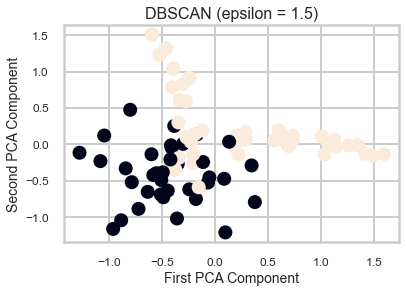

In [357]:
df2['cluster_id'] = cluster_labels
plt.scatter(df2['x'], df2['y'], c=df2['cluster_id']);
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.xlabel('First PCA Component', fontsize=14);
plt.ylabel('Second PCA Component', fontsize=14);
plt.title('DBSCAN (epsilon = 1.5)', fontsize=16);

Taking epsilon = 1.5 seems to be better than 1.0. Interestingly, this clustering gets the two arms, unlike the other clustering techniques with 2 clusters.